## SARIMA


In [2]:
# Libraries
#

import numpy as np
import pandas as pd

from statsmodels.tsa.stattools import adfuller, pacf, pacf_ols
from statsmodels.graphics.tsaplots import plot_pacf

import pmdarima as pm




import matplotlib.pyplot as plt
plt.style.use('ggplot') 
from pandas.plotting import lag_plot

In [3]:
# Establish valid data file path, for reading and saving eg CSV files
#

import os
data_directory = 'Data_Sources'          # Designated data folder above the current working directory
project_directory = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(project_directory, data_directory)
if not os.path.isdir(DATA_PATH):
    raise Exception(f'Directory not found: {DATA_PATH}')

del data_directory, project_directory

In [4]:
# Load the time series CSV

# Load the states .csv file, exit if do not exist or are invalid
file_name = 'hotel_timeseries.csv'
file_path = os.path.join(DATA_PATH, file_name)
if not os.path.isfile(file_path):
    raise Exception(f'File not found: {file_path}')
hotel_time_series_df = pd.read_csv(file_path, parse_dates=['Date'])
hotel_time_series_df.set_index('Date', inplace=True)

# Tidy Up
del file_name, file_path

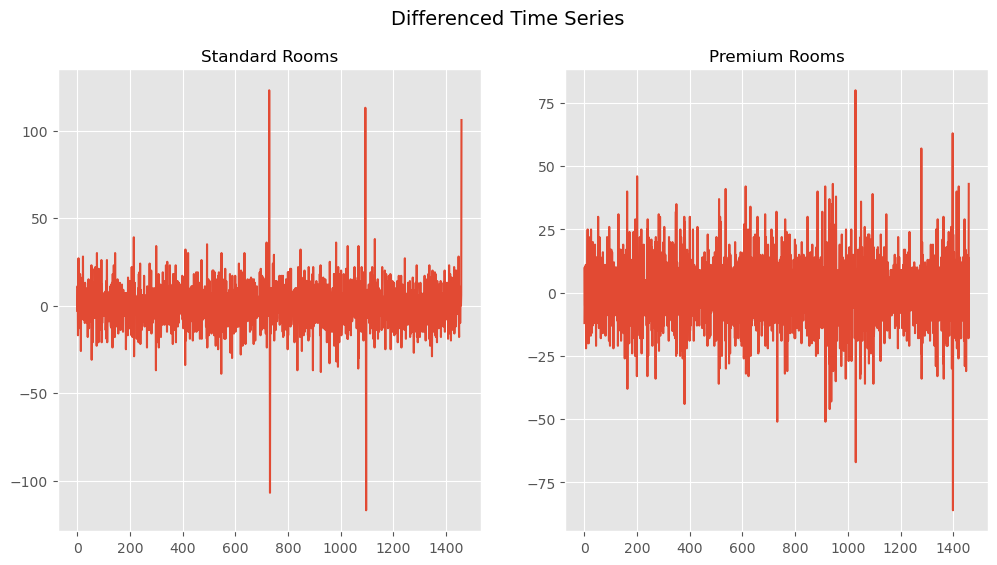

In [5]:
# Perform differencing to make stationary

differenced_series_std = np.diff(hotel_time_series_df['Standard_OCC'])
differenced_series_prm = np.diff(hotel_time_series_df['Premium_OCC'])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('Differenced Time Series', fontsize=14)

ax1.set_title('Standard Rooms', fontsize=12)
ax1.plot(differenced_series_std)
ax2.set_title('Premium Rooms', fontsize=12)
ax2.plot(differenced_series_prm)

### Identify ARMA etc model

order q - look at ACF for the lag when the spikes cross the confidence line
.... ACF plot earlier suggests q is 60
order p - plot PACF

Autofit models - AUTOARIMA
AIC - evaluate the model
- eg ARIMA(0,2,1) is simplest
- SARIMA(p,d,q)(P,D,Q,m)

- P seasonal, autoregressive order AR
- D seasonal, differencing order
- Q seasonal, moving average order MA
- m legth of seasonal cycle, eg 12 for monthly with annual seasonality



?? look at residuals on the selected model
- plot residuals
- Use ACF
- Use Durbin-Watson .. be close to 2

?? forecast evaluation
- accuracy measures: MAE, RMSE .. MAPE



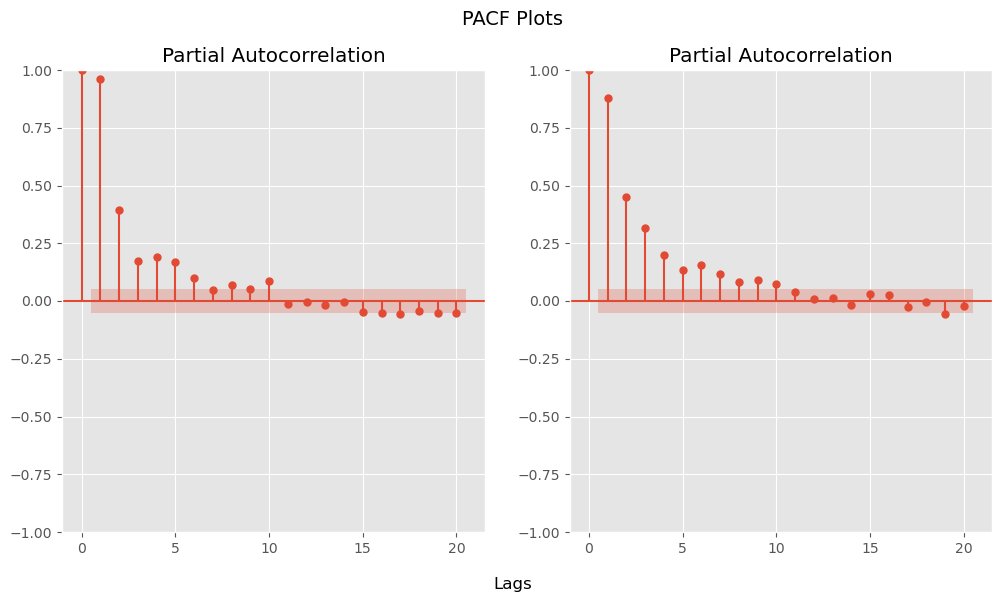

In [6]:
# PACF Plot to identify AR orders, p in ARIMA

lag_value = 20

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle('PACF Plots', fontsize=14)
fig.supxlabel('Lags')

ax1.set_title('Standard Rooms', fontsize=12)
plot_pacf(hotel_time_series_df['Standard_OCC'], lags = lag_value, ax=ax1)
ax2.set_title('Premium Rooms', fontsize=12)
plot_pacf(hotel_time_series_df['Premium_OCC'], lags = lag_value, ax=ax2)


#plt.xlabel('Lags')
#plt.ylabel('PACF')

plt.show()

PACF plot suggests AR order, p of approximately 3

ACF plot earlier suggest MA order q of approximately 60


In [7]:
auto_model = pm.auto_arima(
    hotel_time_series_df['Standard_OCC'],            # Target time series
    start_p=1, max_p=3,         # Range for AR order
    start_q=1, max_q=3,        # Range for MA order
    start_P=0, max_P=2,         # Range for seasonal AR order
    start_Q=0, max_Q=2,         # Range for seasonal MA order
    d=1,                        # Differencing order (can be set to None to auto-detect)
    D=1,                        # Seasonal differencing order (can be set to None to auto-detect)
    m=30,                       # Seasonal cycle length (12 for monthly data with yearly seasonality)
    seasonal=True,              # Enable seasonality
    stepwise=True,              # Enable stepwise search to reduce computation
    trace=True,                 # Print model details during the search
    information_criterion='aic' # Criterion for model selection
)

print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[30]             : AIC=11992.406, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=12471.980, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=11842.510, Time=1.39 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=9.19 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=12238.715, Time=0.17 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=11693.592, Time=4.83 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=51.19 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=12.60 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=11913.276, Time=9.73 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=11656.366, Time=12.63 sec
 ARIMA(2,1,0)(1,1,0)[30]             : AIC=11800.864, Time=2.35 sec
 ARIMA(2,1,0)(2,1,1)[30]             : AIC=inf, Time=75.02 sec
 ARIMA(2,1,0)(1,1,1)[30]             : AIC=inf, Time=10.87 sec
 ARIMA(3,1,0)(2,1,0)[30]             : AIC=11601.946, Time=6.81 sec
 ARIMA(3,1,0)(1,1,0)[30]      

KeyboardInterrupt: 